In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

In [2]:
df=pd.read_csv('/content/TV Shows - Netflix.csv')

In [4]:
df.head()

,Titles,Year,Rating,IMDB_Rating,Netflix
0,Breaking Bad,2008,18+,9.5,1
1,Game of Thrones,2011,18+,9.3,0
2,Rick and Morty,2013,18+,9.2,0
3,Dark,2017,16+,8.8,1
4,Stranger Things,2016,16+,8.8,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Titles       50 non-null     object 
 1   Year         50 non-null     int64  
 2   Rating       50 non-null     object 
 3   IMDB_Rating  50 non-null     float64
 4   Netflix      50 non-null     int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 2.1+ KB


In [6]:
df.describe()

,Year,IMDB_Rating,Netflix
count,50.000000,50.000000,50.000000
mean,2009.900000,8.722000,0.380000
std,6.746881,0.358734,0.490314
min,1989.000000,8.000000,0.000000
25%,2005.250000,8.500000,0.000000
50%,2011.000000,8.700000,0.000000
75%,2015.000000,8.900000,1.000000
max,2019.000000,9.500000,1.000000


In [8]:
df.isnull().sum()

,0
Titles,0
Year,0
Rating,0
IMDB_Rating,0
Netflix,0


In [9]:
df.duplicated().sum()

0

In [11]:
df.nunique()

,0
Titles,50
Year,20
Rating,3
IMDB_Rating,16
Netflix,2


In [13]:
df['Netflix'].value_counts()

,count
Netflix,
0,31
1,19


In [14]:
# Data Visualisation
sns.heatmap(df.corr()>0.4,cmap="RdYlGn",annot=True)

ValueError: could not convert string to float: 'Breaking Bad'

<Axes: >

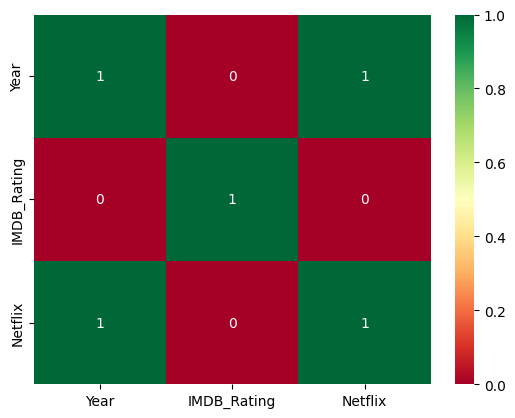

In [15]:
# Data Visualisation
# Select only numerical features for correlation analysis
numerical_df = df.select_dtypes(include=np.number)

# Calculate the correlation matrix for numerical features
correlation_matrix = numerical_df.corr()

# Create the heatmap using the correlation matrix
sns.heatmap(correlation_matrix > 0.4, cmap="RdYlGn", annot=True)

array([[<Axes: title={'center': 'Year'}>,
        <Axes: title={'center': 'IMDB_Rating'}>],
       [<Axes: title={'center': 'Netflix'}>, <Axes: >]], dtype=object)

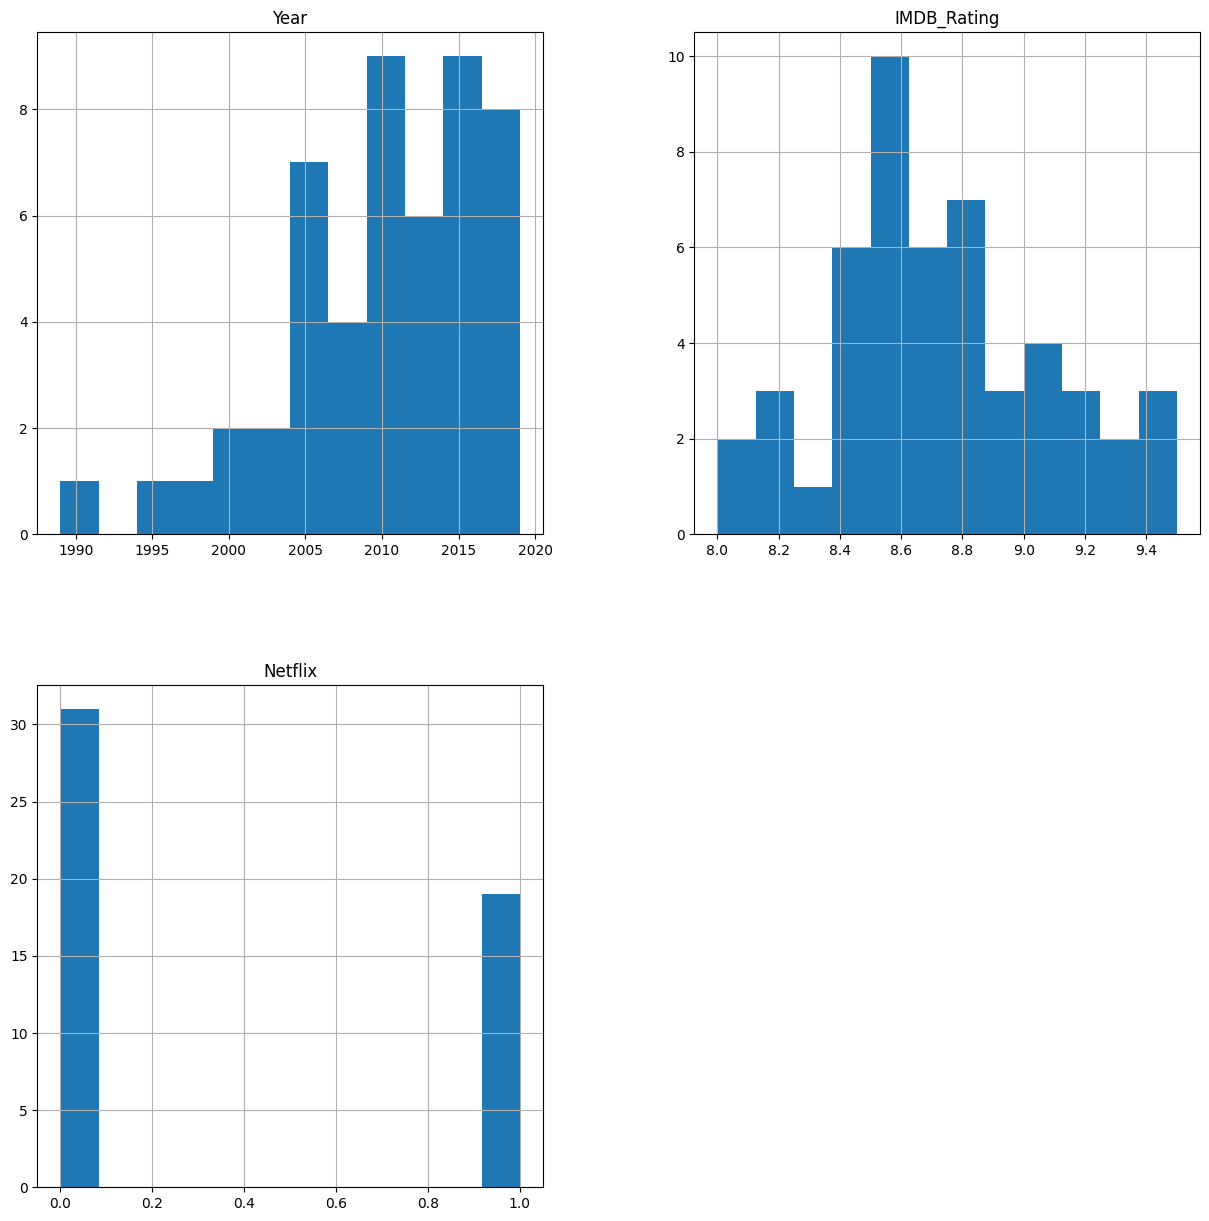

In [16]:
df.hist(figsize=(15,15),bins=12)

In [17]:
df.columns

Index(['Titles', 'Year', 'Rating', 'IMDB_Rating', 'Netflix'], dtype='object')

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA # Import PCA from sklearn.decomposition

X=df.drop('Titles',axis=1)
y=df['Titles']

# Create a LabelEncoder object
le = LabelEncoder()

# Fit and transform the 'artists' column to numerical labels
X['IMDB_Rating'] = le.fit_transform(X['IMDB_Rating'])

# Select only numerical features for scaling
numerical_features = X.select_dtypes(include=np.number).columns
X_numerical = X[numerical_features]

# Create a MinMaxScaler object
mns = MinMaxScaler()

# Fit and transform the numerical features
X_scaled = mns.fit_transform(X_numerical)

# Create a PCA object
pca = PCA(n_components=8)

# Fit and transform the scaled numerical features
X_pca = pca.fit_transform(X_scaled)

#how does array look
X_pca[23,:].reshape(-1,1)

ValueError: n_components=8 must be between 0 and min(n_samples, n_features)=3 with svd_solver='covariance_eigh'

In [21]:
# Create a PCA object with n_components less than or equal to min(n_samples, n_features)
pca = PCA(n_components=3)  # or any number less than or equal to 3

# Fit and transform the scaled numerical features
X_pca = pca.fit_transform(X_scaled)

#how does array look
X_pca[23,:].reshape(-1,1)

array([[-0.52869737],
       [ 0.18691021],
       [-0.56169673]])

In [22]:
from numpy import dot
from numpy.linalg import norm

def cosine_sim(query,index, X_pca): # Add X_pca as an argument
  cosine=[]
  # Access data from X_pca instead of X
  query=np.array(X_pca[query,:])
  for i in range(len(index[0])):
    temp=np.array(X_pca[index[0][i],:]) # Access data from X_pca
    score=dot(query,temp)/(norm(query)*norm(temp))
    cosine.append(score)
  return cosine

In [23]:
from sklearn.neighbors import NearestNeighbors
NN=NearestNeighbors(algorithm='brute',metric='cosine')
# Fit the model using the scaled and PCA-transformed data
NN.fit(X_pca) # Change here to use X_pca which contains the processed data

query=np.random.choice(X_pca.shape[0]) # Update query selection to use X_pca

#need to reshape the data to folow a find neares neighbors
distances,index=NN.kneighbors(X_pca[query,:].reshape(1,-1),n_neighbors=6)
cosine=cosine_sim(query,index, X_pca) # Pass X_pca to cosine_sim
cosine

[1.0000000000000002,
 0.9899404128604193,
 0.986038441059105,
 0.9532975030712499,
 0.9532975030712499,
 0.9241580944049418]

In [27]:
#print the recomendation and their distance
for i in range(len(index[0])):
  if(i==0):
    # Changed 'Title' to 'Titles' to match the actual column name in the DataFrame
    print('recommendation for {0}:'.format(df.iloc[query]['Titles']),end='\n\n')
  else:
    # Changed 'Title' to 'Titles' to match the actual column name in the DataFrame
    print('{}: {},with distance of:{:.4f}'.format(i,df.iloc[index[0][i]]['Titles'],distances.flatten()[i]))

recommendation for The Umbrella Academy:

1: The Witcher,with distance of:0.0101
2: Lucifer,with distance of:0.0140
3: Ozark,with distance of:0.0467
4: Money Heist,with distance of:0.0467
5: The Walking Dead,with distance of:0.0758


In [29]:
#print the recomendation and their distance
for i in range(len(index.flatten())):
  if(i==0):
    print('recommendation for {0}:'.format(df.iloc[query]['Titles']),end='\n\n')
  else:
    print('{}: {},with distance of:{:.2f}'.format(i,df.iloc[index[0][i]]['Titles'],cosine[i]*100))

recommendation for The Umbrella Academy:

1: The Witcher,with distance of:98.99
2: Lucifer,with distance of:98.60
3: Ozark,with distance of:95.33
4: Money Heist,with distance of:95.33
5: The Walking Dead,with distance of:92.42
